# Chargement et pré-traitement des données avec TensorFlow

## Mise en pratique

*Notebook rédigé par l'équipe assistance IA de l'IDRIS, avril 2021*

Ce document présente la méthode à adopter sur Jean Zay pour charger et pré-traiter les données d'entrée pour un entraînement distribué. Il prend comme référence la [documentation TensorFlow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) et illustre la [documentation IDRIS](http://www.idris.fr/jean-zay/gpu/jean-zay-gpu-tf-data-preprocessing.html).

Ce Notebook est composé :
  * d'un [exemple complet](#exemple) de chargement optimisé
  * de [tests de comparaison](#tests) des gains de performance offerts par chaque fonctionnalité présentée dans la documentation (shard, multithreading, prefetching, etc)
  * de l'exemple de création et de l'utilisation des [formats TFRecord](#tfrecord).

### Environnement de calcul

Ce notebook peut être exécuté sur n'importe quel noeud de Jean-Zay mais nous vous conseillons d'utiliser la frontale jupyterhub de Jean-Zay (i.e. une connexion *interactive*) pour éviter de consommer votre allocation. Dans ce cas, le hostname est `jean-zay-srv2` :

In [1]:
!hostname

jean-zay-srv2


Vous devez charger un module TensorFlow ou sélectionner un kernel TensorFlow dans la liste proposée en haut à droite du notebook. Les travaux seront soumis via Slurm dans l'environnement `tensorflow-gpu/py3/2.4.1`.

In [2]:
import glob
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

### Dataset d'images Places365

Dans ce notebook, nous utiliserons la base *Places365* présente dans l'espace de stockage **$DSDIR**.

Ce sont des images classées par thématique (un répertoire par thématique). Nous prendrons la version *data_large* afin de maximiser le travail du chargement des données, lors de nos tests comparatifs.

La base contient 1 803 460 images.

In [3]:
!tree -d -L 2 $DSDIR/Places365-Standard/

/gpfsdswork/dataset/Places365-Standard/
├── data_256
│   ├── a
│   ├── b
│   ├── c
│   ├── d
│   ├── e
│   ├── f
│   ├── g
│   ├── h
│   ├── i
│   ├── j
│   ├── k
│   ├── l
│   ├── m
│   ├── n
│   ├── o
│   ├── p
│   ├── r
│   ├── s
│   ├── t
│   ├── u
│   ├── v
│   ├── w
│   ├── y
│   └── z
├── data_large
│   ├── a
│   ├── b
│   ├── c
│   ├── d
│   ├── e
│   ├── f
│   ├── g
│   ├── h
│   ├── i
│   ├── j
│   ├── k
│   ├── l
│   ├── m
│   ├── n
│   ├── o
│   ├── p
│   ├── r
│   ├── s
│   ├── t
│   ├── u
│   ├── v
│   ├── w
│   ├── y
│   └── z
├── places365_standard
│   ├── train
│   └── val
├── test_256
├── test_large
├── train_image_lmdb
├── val_256
├── val_image_lmdb
└── val_large

59 directories


In [4]:
len(glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/**/*.jpg", recursive=True))

1803460

Afin de reduire les temps de tests et pour pouvoir utiliser la fonction de cache en RAM (sans erreur OOM), nous utiliserons seulement les 3 premières classes commençant par "air". Cela représente **15 000 images pour 3 classes**.

In [6]:
!tree -dsh $DSDIR/Places365-Standard/data_large/a

/gpfsdswork/dataset/Places365-Standard/data_large/a
├── [ 256K]  airfield
├── [ 256K]  airplane_cabin
├── [ 256K]  airport_terminal
├── [ 256K]  alcove
├── [ 256K]  alley
├── [ 256K]  amphitheater
├── [ 256K]  amusement_arcade
├── [ 256K]  amusement_park
├── [ 4.0K]  apartment_building
│   └── [ 256K]  outdoor
├── [ 256K]  aquarium
├── [ 256K]  aqueduct
├── [ 256K]  arcade
├── [ 256K]  arch
├── [ 256K]  archaelogical_excavation
├── [ 256K]  archive
├── [ 4.0K]  arena
│   ├── [ 256K]  hockey
│   ├── [ 256K]  performance
│   └── [ 256K]  rodeo
├── [ 256K]  army_base
├── [ 256K]  art_gallery
├── [ 256K]  artists_loft
├── [ 256K]  art_school
├── [ 256K]  art_studio
├── [ 256K]  assembly_line
├── [ 4.0K]  athletic_field
│   └── [ 256K]  outdoor
├── [ 4.0K]  atrium
│   └── [ 256K]  public
├── [ 256K]  attic
├── [ 256K]  auditorium
├── [ 256K]  auto_factory
└── [ 256K]  auto_showroom

34 directories


In [7]:
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
random.Random(123).shuffle(places365_path)
len(places365_path)

15000

__Remarque__ : La structure de la base n'est pas plate. Certains répertoires ont plusieurs niveaux. Il est necessaire alors d'utiliser un glob récursif. Ce qui nécessite d'utiliser ensuite un tf.data.Dataset.from_tensor_slices, plutôt qu'un tf.data.Dataset.list_files. Il est nécessaire ensuite (puisque les images sont classées par ordre alphabétiques) de faire un *shuffle* sur la liste de chemin, avec un *seed* lorsque l'on utilise la distribution *shard*.

### Exploration du dataset

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(places365_path)

In [10]:
%time len(dataset)

CPU times: user 285 µs, sys: 0 ns, total: 285 µs
Wall time: 302 µs


15000

In [12]:
def decode_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    # decode jpeg format (channel=3 for RGB, channel=0 for Grayscale)
    img = tf.image.decode_jpeg(img, channels=3)
    # convert to [0,1] format for TensorFlow compatibility
    img = tf.image.convert_image_dtype(img, tf.float32)
    return label, img


In [13]:
dataset = dataset.shuffle(5000).map(decode_img, num_parallel_calls=1)

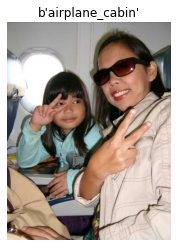

In [14]:
label, image = next(iter(dataset))
plt.imshow(image)
plt.axis('off')
plt.title(label.numpy())
plt.show()

In [15]:
%time len(dataset)

CPU times: user 473 µs, sys: 157 µs, total: 630 µs
Wall time: 500 µs


15000

In [17]:
dataset = dataset.batch(32, drop_remainder=True)

In [18]:
%time len(dataset)

CPU times: user 181 µs, sys: 60 µs, total: 241 µs
Wall time: 189 µs


468

In [20]:
dataset = dataset.repeat(3)

In [21]:
%time len(dataset)

CPU times: user 143 µs, sys: 48 µs, total: 191 µs
Wall time: 199 µs


1404

## Exemple complet de chargement optimisé <a class="anchor" id="exemple"></a>

### Création du script python de chargement des données - version optimisée

In [23]:
%%writefile places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    # decode jpeg format (channel=3 for RGB, channel=0 for Grayscale)
    img = tf.image.decode_jpeg(img, channels=3)
    # convert to [0,1] format for TensorFlow compatibility
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize image
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    # standardize image
    img = tf.image.per_image_standardization(img)
    return label, img


# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')

def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
sharding = True
caching = True
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        caching={caching}, prefetch_factor={prefetch_factor}')
    print(f'------')


# locate Places365 dataset in DSDIR and list places beginning with air
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
random.Random(123).shuffle(places365_path)

# create a dataset object from path
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')

if sharding:
    # get number of processes/workers
    num_workers = idr_tf.size
    worker_index = idr_tf.rank

    # distribute dataset
    dataset = dataset.shard(num_workers,worker_index)
    
    if idr_tf.rank == 0: print(f'Sharded Dataset length = {len(dataset)}')

# shuffling
dataset = dataset.shuffle(shuffling_buffer_size)

# deterministic transformation
dataset = dataset.map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)

if caching:
    dataset = dataset.cache()

# random transformations
dataset = dataset.map(randomized_preprocessing, num_parallel_calls=num_parallel_calls, deterministic=False)
    
# batching
dataset = dataset.batch(batch_size, drop_remainder=True)

# pre-load batches during training
if prefetch_factor:
    dataset = dataset.prefetch(prefetch_factor)

start_time = time.time()

## Repeat a num_epochs times
#dataset = dataset.repeat(num_epochs)
#for label, img in dataset:
#    a = 1 # emulate some action   
## equivalent to:
    
for epoch in range(num_epochs):
    for label, img in dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Overwriting places_loader.py


### Création du script de soumission Slurm

**Rappel**:  si votre unique projet dispose d'heures CPU et GPU ou si votre login est rattaché à plusieurs projets, vous devez impérativement préciser l'attribution sur laquelle doit être décomptée les heures consommées par vos calculs, en ajoutant l'option `--account=my_project@gpu` comme indiqué dans la [documentation IDRIS](http://www.idris.fr/jean-zay/cpu/jean-zay-cpu-doc_account.html).

In [24]:
%%writefile job.slurm
#!/bin/bash
#SBATCH --job-name=data_loader_tensorflow
##SBATCH --account=XXX@v100
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=4
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10
#SBATCH --hint=nomultithread
#SBATCH --exclusive
#SBATCH --time=00:30:00
#SBATCH --output=data_loader_tensorflow.out
#SBATCH --error=data_loader_tensorflow.err

module load tensorflow-gpu/py3/2.4.1

srun python -u places_loader.py

Overwriting job.slurm


### Soumission et exécution de la version optimisée

In [25]:
import time
from IPython.display import clear_output
def display_slurm_queue():
    sq = !squeue -u $USER -n data_loader_tensorflow
    while len(sq) >= 2:
        clear_output(wait=True)
        for l in sq: print(l)
        time.sleep(10)
        sq = !squeue -u $USER -n data_loader_tensorflow
    print('\n Done!')

In [26]:
# submit job
!sbatch job.slurm

Submitted batch job 943702


In [27]:
# should take about 1 min
display_slurm_queue()


 Done!


In [28]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        caching=True, prefetch_factor=-1
------
Dataset length = 15000
Sharded Dataset length = 3750
Execution took 18.59816884994507 s


## Tests des différentes optimisations <a class="anchor" id="tests"></a>

On souhaite ici observer l'impact des différents paramètres présentés dans la documentation sur la performance du pré-traitement des données.
Les paramètres d'intérêt dans les tests ci-dessous sont :
  * le multithreading (num_parallel_calls)
  * la taille de batch
  * la distribution (shard)
  * l'exploitation du cache mémoire 
  * le pré-chargement des batches sur les GPU (prefetch)
  
Il est à noter que ces tests sont exécutés avec une base de données de petite taille. Ce choix a été fait dans un but pédagogique, de manière à ce que l'exécution et la comparaison des performances se fassent rapidement. L'idée est ici de se convaincre du bénéfice de chaque optimisation. Le gain en performance sera potentiellement beaucoup plus avantageux sur une base de données plus grande. A noter que : l'utilisation du cache en RAM ne sera peut-être pas possible avec une base de données plus volumineuse.

----

* Création de dossiers pour stocker
    * les scripts de soumission Slurm
    * les scripts Python de chargement des données
    * les sorties standards des exécutions

In [29]:
!mkdir slurm
!mkdir scripts
!mkdir logs

mkdir: cannot create directory ‘slurm’: File exists
mkdir: cannot create directory ‘scripts’: File exists
mkdir: cannot create directory ‘logs’: File exists


* Script préliminaire de création des scripts Python et Slurm avec des paramètres variables

In [30]:
def create_new_scripts(batch_size=64, num_workers=1, num_parallel_calls=1, sharding=False,
                       caching=False, prefetch_factor=0):
    
    extension = f'{batch_size}_{num_workers}_{num_parallel_calls}_{sharding}_{caching}_{prefetch_factor}'
    slurm_fname=f'slurm/job_{extension}.slurm'
    script_fname=f'scripts/mnist_loader_{extension}.py'
    
    if num_workers <= 4: # mono node
        nnodes = 1
        ntasks_per_node = num_workers
    else: # multi node
        
        if num_workers % 4 != 0:
            print("-- Multi node config: num_workers must be divisible by 4")
            
        nnodes = int(num_workers / 4)
        ntasks_per_node = 4
          
    # create slurm submission script with new number of gpus
    ref_file = open("job.slurm","r")
    new_file = open(slurm_fname,"w")
    for line in ref_file:
        if line.strip().startswith('#SBATCH --nodes='):
            line = f'#SBATCH --nodes={nnodes}\n'        
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --ntasks-per-node='):
            line = f'#SBATCH --ntasks-per-node={ntasks_per_node}\n'        
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --gres=gpu:'):
            line = f'#SBATCH --gres=gpu:{ntasks_per_node}\n'
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --output='):
            line = f'#SBATCH --output=logs/data_loader_{extension}.out\n'
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --error='):
            line = f'#SBATCH --error=logs/data_loader_{extension}.err\n'
            new_file.write(line)
        elif line.strip().startswith('srun'):
            line = f'srun python -u ' + script_fname
            new_file.write(line)
        else:
            new_file.write(line)
            
    # create python script with new parameters
    ref_file = open("places_loader.py","r")
    new_file = open(script_fname,"w")
    for line in ref_file:
        if line.strip().startswith('batch_size = '):
            line = f'batch_size = {batch_size}\n'
            new_file.write(line)
        elif line.strip().startswith('num_parallel_calls = '):
            line = f'num_parallel_calls = {num_parallel_calls}\n'
            new_file.write(line)
        elif line.strip().startswith('sharding = '):
            line = f'sharding = {sharding}\n'
            new_file.write(line)
        elif line.strip().startswith('caching = '):
            line = f'caching = {caching}\n'
            new_file.write(line)
        elif line.strip().startswith('prefetch_factor = '):
            line = f'prefetch_factor = {prefetch_factor}\n'
            new_file.write(line)
        else:
            new_file.write(line)
          
    return slurm_fname

### Résultats de référence -- version sous optimisée

Le résultat de référence correspond à une version sous optimisée des paramètres :
* multithreading désactivé (num_parallel_calls=1)
* taille de batch = 64
* nombre de workers = 1
* pas de sharding
* pas de caching
* pas de pré-chargement (prefetch)

In [31]:
# create and execute reference scripts
slurm_fname = create_new_scripts()
print(slurm_fname)
!sbatch $slurm_fname

slurm/job_64_1_1_False_False_0.slurm
Submitted batch job 943720


In [32]:
# should take about 6 min
display_slurm_queue()


 Done!


In [33]:
!cat logs/data_loader_64_1_1_False_False_0.out

 --- Running on 1 workers / 1 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=1,
        shuffling_buffer_size=5000, num_workers=1,
        caching=False, prefetch_factor=0
------
Dataset length = 15000
Execution took 264.69685649871826 s


### Multithreading - Nombre de calls parallèles

* Estimation du gain de temps lorsque l'on augmente le nombre de calls parallèles

In [34]:
# create and execute scripts with increasing number of num_parallel_calls
for num_parallel_calls in [2, 8, 10, 16]:
    slurm_fname = create_new_scripts(num_parallel_calls=num_parallel_calls)
    !sbatch $slurm_fname

Submitted batch job 943816
Submitted batch job 943818
Submitted batch job 943822
Submitted batch job 943829


In [35]:
display_slurm_queue()


 Done!


In [36]:
%%bash
for n in 1 2 8 10 16
do
    echo ">>> num_parallel_calls = $n" 
    grep "Execution took" logs/data_loader_64_1_${n}_False_False_0.out
done

>>> num_parallel_calls = 1
Execution took 264.69685649871826 s
>>> num_parallel_calls = 2
Execution took 323.4611339569092 s
>>> num_parallel_calls = 8
Execution took 155.9432179927826 s
>>> num_parallel_calls = 10
Execution took 158.35249400138855 s
>>> num_parallel_calls = 16
Execution took 158.52406096458435 s


__Remarque__ :  Le nombre optimal d'appels parallèles dépend de la taille des entrèes et de la taille du batch. tf.data.AUTOTUNE permet d'automatiser cette optimisation.

### Taille de batch

* Estimation du gain de temps lorsque l'on augmente la taille de batch

In [37]:
# create and execute scripts with increasing batch size (batch_size=8 already done in ref job)
for batch_size in [16, 32, 128, 256]:
    slurm_fname = create_new_scripts(batch_size=batch_size)
    !sbatch $slurm_fname

Submitted batch job 943927
Submitted batch job 943930
Submitted batch job 943933
Submitted batch job 943935


In [38]:
display_slurm_queue()


 Done!


In [39]:
%%bash
for size in 16 32 64 128 256
do
    echo ">>> batch_size = $size" 
    grep "Execution took" logs/data_loader_${size}_1_1_False_False_0.out
done

>>> batch_size = 16
Execution took 484.84338188171387 s
>>> batch_size = 32
Execution took 440.23880791664124 s
>>> batch_size = 64
Execution took 264.69685649871826 s
>>> batch_size = 128
Execution took 264.7972962856293 s
>>> batch_size = 256
Execution took 265.0397357940674 s


### Nombre de workers - Avec sharding

* Estimation du gain de temps lorsque l'on augmente le nombre de workers partagés

In [40]:
# create and execute scripts with increasing number of workers (num_workers=1 already done in ref job)
for num_workers in [1,2,4,8,16]:
    slurm_fname = create_new_scripts(num_workers=num_workers, sharding=True)
    !sbatch $slurm_fname

Submitted batch job 944865
Submitted batch job 944866
Submitted batch job 944867
Submitted batch job 944868
Submitted batch job 944869


In [41]:
display_slurm_queue()


 Done!


In [42]:
%%bash
for n in 1 2 4 8 16
do
    echo ">>> num_workers = $n" 
    grep "Execution took" logs/data_loader_64_${n}_1_True_False_0.out
done

>>> num_workers = 1
Execution took 485.73223328590393 s
>>> num_workers = 2
Execution took 272.958291053772 s
>>> num_workers = 4
Execution took 117.9092378616333 s
>>> num_workers = 8
Execution took 62.34236240386963 s
>>> num_workers = 16
Execution took 17.70249581336975 s


### Caching

* Estimation du gain de temps lorsque l'on utilise le cache en RAM

In [43]:
slurm_fname = create_new_scripts(caching=True)
!sbatch $slurm_fname

Submitted batch job 944640


In [44]:
display_slurm_queue()


 Done!


In [45]:
%%bash
echo ">>> caching = False" 
grep "Execution took" logs/data_loader_64_1_1_False_False_0.out
echo ">>> caching = True" 
grep "Execution took" logs/data_loader_64_1_1_False_True_0.out

>>> caching = False
Execution took 264.69685649871826 s
>>> caching = True
Execution took 326.0158724784851 s


### Prefetching

* Estimation du gain de temps lorsque l'on utilise et que l'on augmente la taille du buffer

In [46]:
for prefetch_factor in [2, 5, 10]:
    slurm_fname = create_new_scripts(prefetch_factor=prefetch_factor)
    !sbatch $slurm_fname

Submitted batch job 944683
Submitted batch job 944684
Submitted batch job 944686


In [47]:
display_slurm_queue()


 Done!


In [48]:
%%bash
for n in 0 2 5 10
do
    echo ">>> prefetch_factor = $n" 
    grep "Execution took" logs/data_loader_64_1_1_False_False_${n}.out
done

>>> prefetch_factor = 0
Execution took 264.69685649871826 s
>>> prefetch_factor = 2
Execution took 270.52130651474 s
>>> prefetch_factor = 5
Execution took 348.5388197898865 s
>>> prefetch_factor = 10
Execution took 307.8827257156372 s


__Remarque__ :  Ici, dans notre test il ne se passe rien dans le GPU, donc le prefetch n'a aucun intérêt. Cependant dans un apprentissage solicitant intensément les GPU, le prefetch est fortement conseillé. Le nombre optimal d'appels parallèles dépend du rapport de congestion entre CPU et GPU. tf.data.AUTOTUNE permet d'automatiser cette optimisation.

## Format TFRecord <a class="anchor" id="tfrecord"></a>

Le Format TFRecord est optimisé pour un gain de temps en lecture. C'est une bonne pratique de les utiliser.

### Dataset au format TFRecord unique

Lorsque l'on centralise tout le *dataset* dans un seul *TFrecord*.

Notre fichier personnel au format *TFRecord* sera enregistré dans notre espace **SCRATCH** personnel.

#### Création et écriture du TFRecord

In [49]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [50]:
# Create a dictionary with features that may be relevant.
def image_example(label, image_string):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
          'height': _int64_feature(image_shape[0]),
          'width': _int64_feature(image_shape[1]),
          'depth': _int64_feature(image_shape[2]),
          'label': _bytes_feature(label),
          'image_raw': _bytes_feature(image_string ),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)) 

In [51]:
def parse_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    
    return label, img

In [52]:
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
dataset = dataset.map(parse_img, num_parallel_calls=1)

In [53]:
record_file = os.environ['SCRATCH']+'/places365.tfrecords'

In [54]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.

with tf.io.TFRecordWriter(record_file) as writer:
    for label, image in tqdm(iter(dataset)):
        tf_example = image_example(label, image)
        writer.write(tf_example.SerializeToString())


15000it [01:02, 241.62it/s]


#### Lecture et chargement du TFRecord

In [55]:
tfr_dataset = tf.data.TFRecordDataset(record_file)

In [56]:
for raw_record in tfr_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 512
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\000\003\002\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#

In [57]:
def tf_parse(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    image, label = example['image_raw'][0], example['label'][0]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return label, image

In [58]:
tfr_dataset = tfr_dataset.shuffle(5000).map(tf_parse, num_parallel_calls=1)

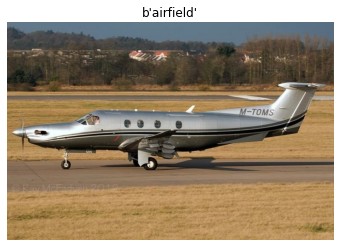

In [59]:
label, image = next(iter(tfr_dataset))
plt.imshow(image)
plt.axis('off')
plt.title(label.numpy())
plt.show()

__Remarque__ : Le Dataset chargé à partir du TF Record ne connait pas sa taille. Il faudra trouver l'information dans la base *source* qui a permis de créer le TFRecord. 

In [60]:
# Uncomment this line will cause an error
#len(tfr_dataset)

In [61]:
len(dataset)

15000

### Création du script python de chargement des données - version optimisée

In [63]:
%%writefile tfr_places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    img, label = example['image_raw'][0], example['label'][0]
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img = tf.image.per_image_standardization(img)
    return label, img

# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')
def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        prefetch_factor={prefetch_factor}')
    print(f'------')


# Search the length of dataset
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')

    
# Load the unique TFRecord Dataset
record_file = os.environ['SCRATCH']+'/places365.tfrecords'
tfr_dataset = tf.data.TFRecordDataset(record_file)
num_workers = idr_tf.size
worker_index = idr_tf.rank
tfr_dataset = (tfr_dataset.shard(num_workers,worker_index)
                          .shuffle(shuffling_buffer_size)
                          .map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)
                          .cache()
                          .map(randomized_preprocessing, num_parallel_calls=num_parallel_calls,deterministic=False)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(prefetch_factor)              
              )
              
start_time = time.time()
    
for epoch in range(num_epochs):
    for label, img in tfr_dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Writing tfr_places_loader.py


### Création du script de soumission Slurm

**Rappel**:  si votre unique projet dispose d'heures CPU et GPU ou si votre login est rattaché à plusieurs projets, vous devez impérativement préciser l'attribution sur laquelle doit être décomptée les heures consommées par vos calculs, en ajoutant l'option `--account=my_project@gpu` comme indiqué dans la [documentation IDRIS](http://www.idris.fr/jean-zay/cpu/jean-zay-cpu-doc_account.html).

In [64]:
%%writefile job.slurm
#!/bin/bash
#SBATCH --job-name=data_loader_tensorflow
##SBATCH --account=XXX@v100
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=4
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10
#SBATCH --hint=nomultithread
#SBATCH --exclusive
#SBATCH --time=00:30:00
#SBATCH --output=data_loader_tensorflow.out
#SBATCH --error=data_loader_tensorflow.err

module load tensorflow-gpu/py3/2.4.1

srun python -u tfr_places_loader.py

Overwriting job.slurm


In [65]:
# submit job
!sbatch job.slurm

Submitted batch job 944812


In [66]:
# should take about 30 sec
display_slurm_queue()


 Done!


In [67]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        prefetch_factor=-1
------
Dataset length = 15000
Execution took 18.489180326461792 s


### Dataset au format TFRecord partagé

**Pour les grosses bases de données**, il est préférable de segmenter le dataset en plusieurs fichiers *TFrecord*. Lorsque l'on utilise le **sharding**, cela est conseillé car cela permet que chaque *worker* ne lise qu'une partie des fichiers *TFRecord*.

#### Création et écriture du TFRecord partagé

**Il est important que chaque partie possède le même nombre d'exemple**, afin d'avoir le même nombre de *batch* dans chaque *process* lorsque l'on utilise le *sharding*.

Ici on le partage en 8 parties. Pour de grosses bases, il est préférable de les partitionner en un nombre supérieur (128, 256, 512, ... parties)

In [68]:
part_places365_path= np.array(places365_path).reshape(8,-1)
part_places365_path.shape

(8, 1875)

In [70]:
part_dataset = [tf.data.Dataset.from_tensor_slices(part_places365_path[i]).map(parse_img, num_parallel_calls=1)
                for i in range(len(part_places365_path))]

In [71]:
part_record_file = [os.environ['SCRATCH']+f'/places365_{i}.tfrecords' for i in range(len(part_dataset))]

# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.

for i in range(len(part_dataset)):
    with tf.io.TFRecordWriter(part_record_file[i]) as writer:
        for label, image in tqdm(iter(part_dataset[i])):
            tf_example = image_example(label, image)
            writer.write(tf_example.SerializeToString())


1875it [00:11, 168.89it/s]
1875it [00:10, 178.52it/s]
1875it [00:10, 173.57it/s]
1875it [00:10, 176.60it/s]
1875it [00:10, 172.09it/s]
1875it [00:08, 230.83it/s]
1875it [00:04, 377.30it/s]
1875it [00:05, 346.32it/s]


In [72]:
glob.glob(os.environ['SCRATCH']+'/places365_*.tfrecords')

['/gpfsscratch/idris/sos/ssos938/places365_4.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_2.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_7.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_0.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_3.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_5.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_1.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_6.tfrecords']

#### Lecture et chargement des TFRecords

### Création du script python de chargement des données - version optimisée

In [74]:
%%writefile tfr_places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    img, label = example['image_raw'][0], example['label'][0]
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img = tf.image.per_image_standardization(img)
    return label, img

# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')
def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        prefetch_factor={prefetch_factor}')
    print(f'------')


# Search the length of dataset
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')
    
# Load the unique TFRecord Dataset

tfr_dataset = tf.data.Dataset.list_files(os.environ['SCRATCH']+'/places365_*.tfrecords')
num_workers = idr_tf.size
worker_index = idr_tf.rank
tfr_dataset = (tfr_dataset.shard(num_workers,worker_index)
                          .shuffle(shuffling_buffer_size)
                          .interleave(tf.data.TFRecordDataset, cycle_length=idr_tf.cpus_per_task, block_length=1)
                          .map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)
                          .cache()
                          .map(randomized_preprocessing, num_parallel_calls=num_parallel_calls,deterministic=False)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(prefetch_factor)
              )
               
start_time = time.time()
    
for epoch in range(num_epochs):
    for label, img in tfr_dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Overwriting tfr_places_loader.py


In [75]:
# submit job
!sbatch job.slurm

Submitted batch job 944862


In [76]:
# should take about 30 sec
display_slurm_queue()


 Done!


In [77]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        prefetch_factor=-1
------
Dataset length = 15000
Execution took 18.115662813186646 s
